In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [4]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

16384/10484 [==============================================] - 0s 0us/step


In [5]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

811008/802859 [==============================] - 0s 0us/step


In [6]:
img_name_tensors.keys()

dict_keys(['Fireboat', 'Giant Panda'])

In [7]:
img_name_tensors['Fireboat'].shape

TensorShape([224, 224, 3])

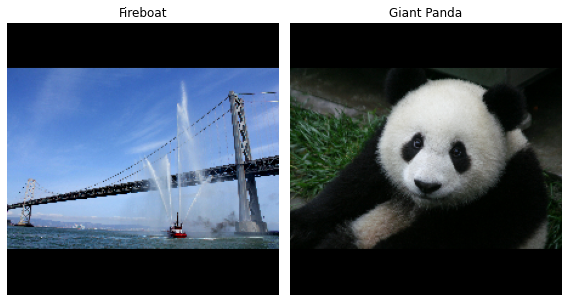

In [8]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

## 이미지 분류
샘플 사진들의 가장 확신도가 높은 클래스들을 표현한다.

In [9]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

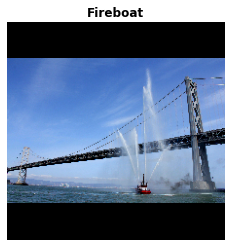

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


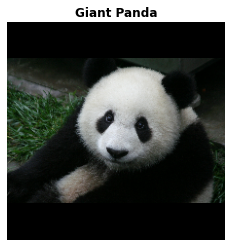

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [10]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## IG 계산

Inception V1 모델은 입력특징공간과 이미지넷 클래스 확률수치 사이의 매핑을 학습한다. 초기 해석방법들은 특징의 중요도를 gradient로 할당했는데, 
이런 방식은 모델의 예측함수를 따라 주어진 지점에서의 가장 가파른 경사를 갖는 픽셀을 말해준다. 그러나 gradient는 픽셀값과 관련해서 예측함수의 지역적인 변화만을 설명하며 전체적인 예측함수의 기능을 설명하지 않는다. 우리 모델이 개별 픽셀의 범위와 올바른 이미지넷 클래스의 관계를 완전히 학습함에 따라, 이 픽셀의 gradient가 포화되고, 점차 작아져 심지어 0이 될 수 있다.


In [11]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

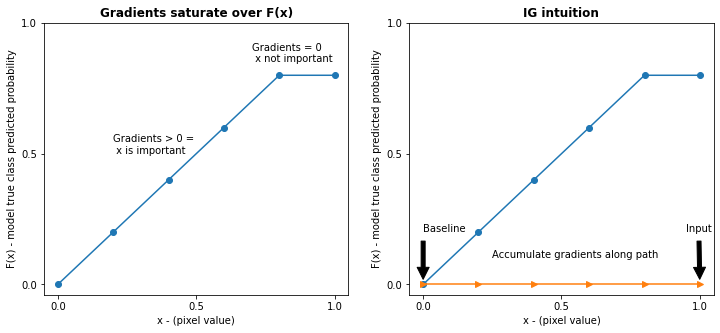

In [12]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

## Baseline

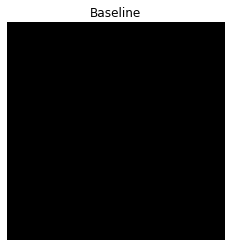

In [13]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [64]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [65]:
alphas

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
       0.09999999, 0.12      , 0.14      , 0.16      , 0.17999999,
       0.19999999, 0.22      , 0.24      , 0.26      , 0.28      ,
       0.29999998, 0.32      , 0.34      , 0.35999998, 0.38      ,
       0.39999998, 0.42      , 0.44      , 0.45999998, 0.48      ,
       0.5       , 0.52      , 0.53999996, 0.56      , 0.58      ,
       0.59999996, 0.62      , 0.64      , 0.65999997, 0.68      ,
       0.7       , 0.71999997, 0.74      , 0.76      , 0.78      ,
       0.79999995, 0.82      , 0.84      , 0.85999995, 0.88      ,
       0.9       , 0.91999996, 0.94      , 0.96      , 0.97999996,
       1.        ], dtype=float32)>

In [66]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [67]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

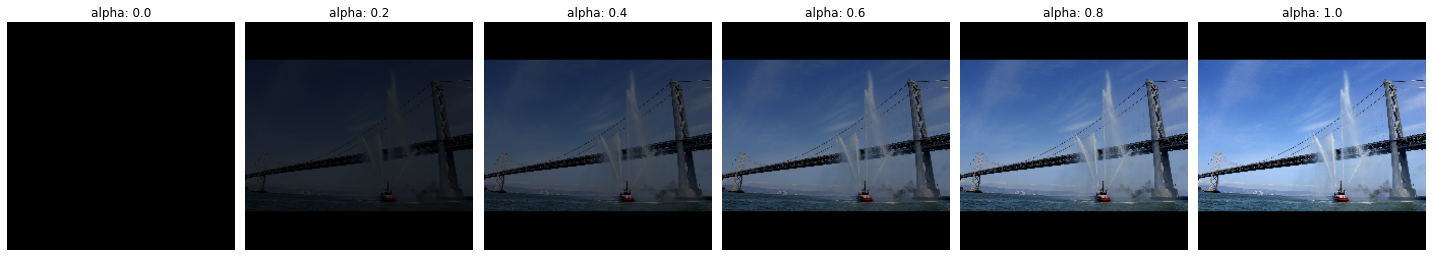

In [68]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [24]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [25]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

In [32]:
interpolated_images.shape

TensorShape([51, 224, 224, 3])

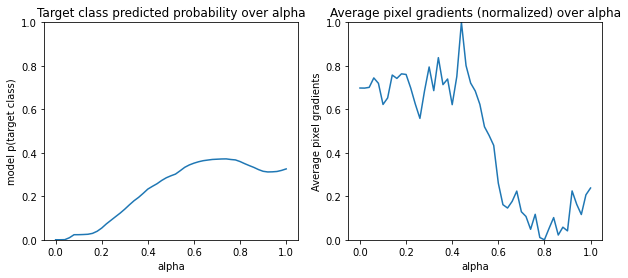

In [55]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [33]:
pred.shape

TensorShape([51, 1001])

In [28]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [29]:
ig = integral_approximation(
    gradients=path_gradients)

In [34]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [35]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

In [45]:
ig_attributions.shape

TensorShape([224, 224, 3])

In [60]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

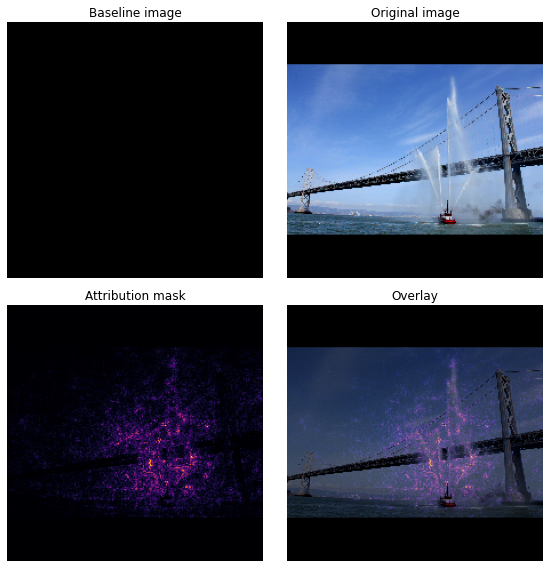

In [61]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

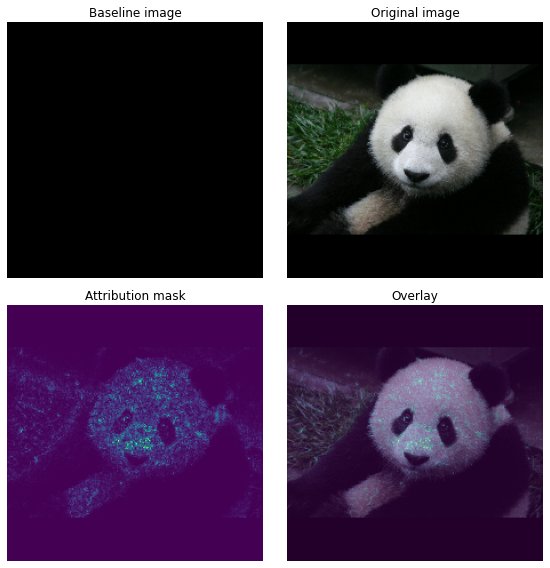

In [62]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=389,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)